In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling

In [23]:
A = np.genfromtxt("fault-synth.mag", names=True)
print(A.dtype)

[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('TFA', '<f8'), ('Bx', '<f8'), ('By', '<f8'), ('Bz', '<f8'), ('Bxx', '<f8'), ('Bxy', '<f8'), ('Bxz', '<f8'), ('Byy', '<f8'), ('Byz', '<f8'), ('Bzz', '<f8')]


In [24]:
points = np.column_stack([A["x"], A["y"], -A["z"]])
# plt.plot(A["x"], A["y"], ".")
dx = 50.
x = np.arange(-600, 601, dx)
z = z=np.arange(-800, 1, dx)
grid = mt.createGrid(x=x, y=x, z=z)
print(grid)

Mesh: Nodes: 10625 Cells: 9216 Boundaries: 28992


In [25]:
import pyIGRF
igrf = pyIGRF.igrf_value(lat=50.59465, lon=12.64139)
fopT = MagneticsModelling(grid.NED(), points, cmp=["TFA"], igrf=igrf)
# fop = MagneticsModelling(grid.NED(), points, cmp=["Bx", "By", "Bz"], igrf=igrf)

   0%|          |0/861 [00:00 < ?]

In [26]:
bz = np.array([abs(b.center().z()) for b in grid.boundaries() if not b.outside()])
cz = np.abs(pg.z(grid.cellCenter()))
z0 = 25
a0 = 100
wb = 100 / (bz+z0)**1.5
wc = 100 / (cz+z0)**1.5
print(min(wb), max(wb), min(wc), max(wc))

0.004419417382415922 0.282842712474619 0.004419417382415922 0.282842712474619


In [27]:
noise_level = 3
data = A["TFA"]
data += np.random.randn(len(data)) * noise_level

In [28]:
invT = pg.Inversion(fop=fopT, verbose=True)
cType = 1
invT.setRegularization(cType=cType, limits=[0, 0.1])  # to limit values
if cType == 2:
    invT.setConstraintWeights(wc)
else:
    invT.setConstraintWeights(wb)
    
grid["invT"] = invT.run(data, absoluteError=noise_level, lam=100, startModel=1e-3, verbose=True)

18/11/23 - 11:39:25 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x0000026454C17C20>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000026454D68EE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000026454D68DC0>
min/max (data): -45.12/217
min/max (error): 1.38%/4.8e+04%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  165.71
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   50.91 (dPhi = 69.15%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   42.06 (dPhi = 17.22%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   33.39 (dPhi = 20.36%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² 

In [29]:
fault = mt.readPLC("fault.poly")
print(fault)

Mesh: Nodes: 8 Cells: 0 Boundaries: 6


In [30]:
pl, _ = pg.show(grid, label="invT", style="surface", hold=True, backend="trame",
                filter={"threshold": dict(value=0.025, scalars="invT")})
pv.drawModel(pl, fault, style="wireframe")
pv.drawMesh(pl, grid, label="invT", style="surface", cMap="Spectral_r", cMin=0, cMax=0.05,
            filter={"slice": dict(normal=[-1, 0, 0], origin=[0, 0, 0])})
pl.camera_position = "yz"
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

Widget(value="<iframe src='http://localhost:65111/index.html?ui=P_0x26455050f10_5&reconnect=auto' style='width…

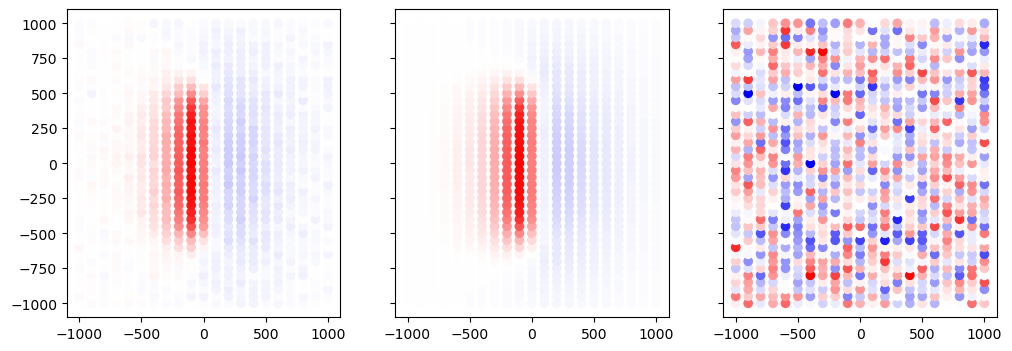

In [31]:
fig, ax = pg.plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)
vals = data
mm = np.max(np.abs(vals))
ax[0].scatter(A["x"], A["y"], c=vals, cmap="bwr", vmin=-mm, vmax=mm);
ax[1].scatter(A["x"], A["y"], c=invT.response, cmap="bwr", vmin=-mm, vmax=mm);
misfit = (data - invT.response) / noise_level
ax[2].scatter(A["x"], A["y"], c=misfit, cmap="bwr", vmin=-3, vmax=3);

In [32]:
fopB = MagneticsModelling(grid.NED(), points, cmp=["Bx", "By", "Bz"], igrf=igrf)

   0%|          |0/861 [00:00 < ?]

In [33]:
data = np.concatenate([A["B"+t] for t in "xyz"])
data += np.random.randn(len(data)) * noise_level

In [34]:
invB = pg.Inversion(fop=fopB, verbose=True)
invB.setRegularization(limits=[0, 0.1])  # to limit values
invB.setConstraintWeights(wb)
grid["invB"] = invB.run(data, absoluteError=noise_level, lam=100, startModel=1e-3, verbose=True)

18/11/23 - 11:40:55 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x0000026455C0E720>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000263EAC58280>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000263EAC586A0>
min/max (data): -138/214
min/max (error): 1.4%/3.8e+06%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  113.56
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   33.42 (dPhi = 70.50%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   27.38 (dPhi = 17.97%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   20.91 (dPhi = 23.46%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =  

In [35]:
pl, _ = pg.show(grid, label="invB", style="surface", hold=True, backend="trame",
                filter={"threshold": dict(value=0.02, scalars="invB")})
pv.drawModel(pl, fault, style="wireframe")
pv.drawMesh(pl, grid, label="invB", style="surface", cMap="Spectral_r", cMin=0, cMax=0.05,
            filter={"slice": dict(normal=[-1, 0, 0], origin=[0, 0, 0])})
pl.camera_position = "yz"
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

Widget(value="<iframe src='http://localhost:65111/index.html?ui=P_0x263eac4bfd0_6&reconnect=auto' style='width…

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2647fb56a30>)

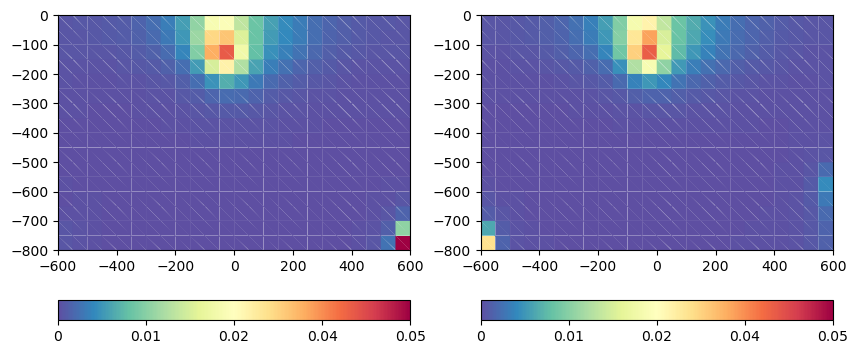

In [36]:
sli = mt.extract2dSlice(grid, normal="x")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pg.show(sli, "invT", cMin=0, cMax=0.05, cMap="Spectral_r", ax=ax[0])
pg.show(sli, "invB", cMin=0, cMax=0.05, cMap="Spectral_r", ax=ax[1])

In [37]:
inv = pg.Inversion(fop=fopB, verbose=True)
inv.setRegularization(limits=[0, 0.1], correlationLengths=[200, 200, 50], dip=-70)
# inv.setConstraintWeights(wc)
grid["invC"] = inv.run(data, absoluteError=noise_level, lam=100, startModel=1e-3, verbose=True, maxIter=4)

18/11/23 - 11:53:56 - pyGIMLi - INFO - Starting inversion.
18/11/23 - 11:53:56 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[200, 200, 50], dip=-70, strike=0
18/11/23 - 11:53:56 - pyGIMLi - INFO - Creating forward mesh from region infos.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x0000026455C0E720>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000264B874F880>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000264701070A0>
min/max (data): -138/214
min/max (error): 1.4%/3.8e+06%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------


18/11/23 - 11:53:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/11/23 - 11:53:58 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 79233 Cells: 73728 Boundaries: 115968
Mesh contains data: invT
18/11/23 - 11:54:06 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\math\matrix.py:createCm05 restored (41.7s x 1): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\1756140332703366157


inv.iter 0 ... chi² =  113.56
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   18.89 (dPhi = 83.32%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.10 (dPhi = 67.36%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.32 (dPhi = 76.66%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.99 (dPhi = 21.87%) lam: 100.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.99)                   #
################################################################################


In [38]:
pl, _ = pg.show(grid, label="invC", style="surface", hold=True, backend="trame",
                filter={"threshold": dict(value=0.02, scalars="invC")})
pv.drawModel(pl, fault, style="wireframe")
pv.drawMesh(pl, grid, label="invC", style="surface", cMap="Spectral_r", cMin=0.001, cMax=0.05,
            filter={"slice": dict(normal=[-1, 0, 0], origin=[0, 0, 0])})
pl.camera_position = "yz"
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

18/11/23 - 11:57:44 - root - ERROR - Exception raised
18/11/23 - 11:57:44 - root - ERROR - KeyError('a939d4970b88c2ee2e9a70a314f2d65a_942d')
18/11/23 - 11:57:44 - root - ERROR - Traceback (most recent call last):
  File "c:\Program Files\software\Anaconda\envs\pg14\lib\site-packages\wslink\backends\aiohttp\__init__.py", line 493, in onMessage
    results = func(*args, **kwargs)
  File "c:\Program Files\software\Anaconda\envs\pg14\lib\site-packages\trame_vtk\modules\vtk\protocols\local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "c:\Program Files\software\Anaconda\envs\pg14\lib\site-packages\trame_vtk\modules\vtk\serializers\synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: 'a939d4970b88c2ee2e9a70a314f2d65a_942d'

18/11/23 - 11:57:44 - root - ERROR - Exception raised
18/11/23 - 11:57:44 - root - ERROR - KeyError('70621650a37cd11f9690289e537f5b30_1530L')
18/11/23 

Widget(value="<iframe src='http://localhost:65111/index.html?ui=P_0x264899a9d60_7&reconnect=auto' style='width…